# 289to305 (16-31 Oktober)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Oct16-31woP.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_AGS_289to305']
X = df.loc[:, ~df.columns.isin(['std_inz_AGS_289to305'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  147


# First RF Model with 147 features

In [4]:
rfr = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5000, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)
rf=rfr.fit(X, Y)  
rf.score(X, Y)

0.9437513738965189

In [5]:
y_pred = rf.predict(X)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y, y_pred)))


Root Mean Squared Error: 23.706662838011024


# SHAP VAlues

In [6]:
shap_values_rf = shap.TreeExplainer(rf).shap_values(X)

def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_rf,X) 

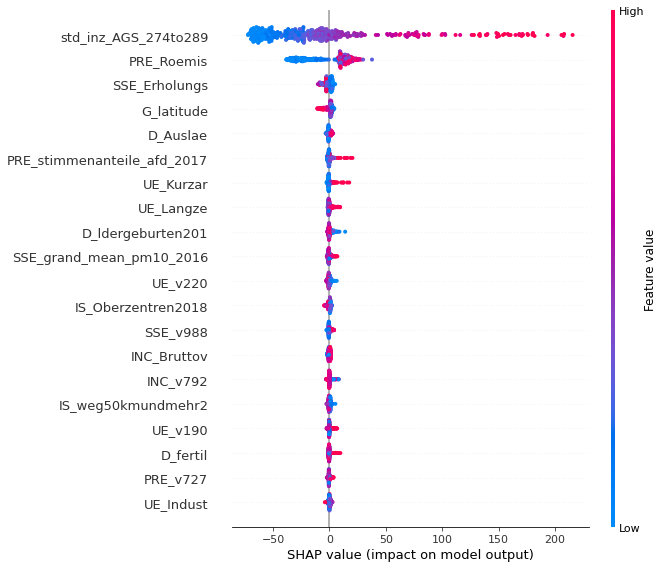

In [8]:
shap.summary_plot(shap_values_rf,X)

# Second CatBoost model with 20 most important features

In [9]:
top20feature = X.columns[np.argsort(np.abs(shap_values_rf).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_rf).mean(0))][-10:][::-1]

In [10]:
rf_20=rfr.fit(X[top20feature], Y)  
rf_20.score(X[top20feature], Y)


0.9485932327067168

In [11]:
y_pred_20 = rf_20.predict(X[top20feature])

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y, y_pred_20)))


Root Mean Squared Error: 22.66337634350857


# Compare top 10 features of both Models

In [12]:
shap_values_rf_20 = shap.TreeExplainer(rf_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_rf_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_274to289', 'PRE_Roemis', 'SSE_Erholungs', 'G_latitude', 'D_Auslae', 'PRE_stimmenanteile_afd_2017', 'UE_Kurzar', 'UE_Langze', 'D_ldergeburten201', 'SSE_grand_mean_pm10_2016'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_274to289', 'PRE_Roemis', 'G_latitude', 'SSE_Erholungs', 'D_ldergeburten201', 'UE_Langze', 'UE_Kurzar', 'PRE_stimmenanteile_afd_2017', 'D_Auslae', 'SSE_v988']


In [13]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_274to289
PRE_Roemis
SSE_Erholungs
G_latitude
D_Auslae
PRE_stimmenanteile_afd_2017
UE_Kurzar
UE_Langze
D_ldergeburten201


ABS_SHAP(shap_values_rf_20,X[top20feature]) 

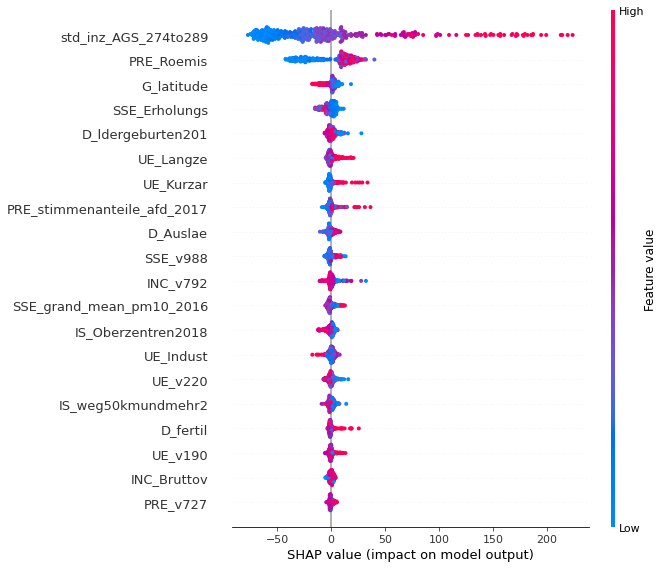

In [15]:
shap.summary_plot(shap_values_rf_20,X[top20feature])

# Hold out validation of the second model

In [16]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_rf_train_top20 = list(range(0,20))
r2_rf_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    rf_test_x = X[top20feature].iloc[rs]
    rf_test_y = Y.iloc[rs]
    rf_train_x = X[top20feature].drop(rs)
    rf_train_y = Y.drop(rs)   
    
    #fit the model
    rf_k=rfr.fit(rf_train_x, rf_train_y)
    
    # make the prediction using the resulting model
    preds_k = rf_k.predict(rf_test_x)
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(rf_test_y), preds_k, "RMSE")[0]  
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, rf_test_y)

    
    r2_rf_train_top20[i] = rf_k.score(rf_train_x,rf_train_y)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, rf_test_y)

    r2_rf_test_top20[i] =  rf_k.score(rf_test_x, rf_test_y)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [17]:
print("Mean R2 of RF_models on train sets with top20 features:",sum(r2_rf_train_top20)/len(r2_rf_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of RF_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of RF_models on test sets with top20 features:",sum(r2_rf_test_top20)/len(r2_rf_test_top20))

Mean R2 of RF_models on train sets with top20 features: 0.9471188391896834
Mean R2 of linReg_modesl with top20 features:  0.6313033485307125
Mean RMSE of RF_models on test sets with top20 features:  61.81841210522391
Mean R2 of RF_models on test sets with top20 features: 0.6248066766906748


# descriptives of top20 features

In [18]:
X[top20feature].describe()

,std_inz_AGS_274to289,PRE_Roemis,SSE_Erholungs,G_latitude,D_Auslae,PRE_stimmenanteile_afd_2017,UE_Kurzar,UE_Langze,D_ldergeburten201,SSE_grand_mean_pm10_2016,UE_v220,IS_Oberzentren2018,SSE_v988,INC_Bruttov,INC_v792,IS_weg50kmundmehr2,UE_v190,D_fertil,PRE_v727,UE_Indust
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,52.453857,32.242802,70.509460,50.615307,10.034916,13.388280,0.752618,32.202728,16.510971,14.254108,34.556614,22.563591,33367.324219,2337.790527,3039.725586,11.484292,11.710723,1.632220,11.654364,18.253864
std,36.794933,24.361443,56.734703,1.740311,5.149191,5.329521,1.440882,8.077897,8.783778,2.204698,13.284161,16.033615,30681.789062,806.781372,1074.388306,3.481254,3.008996,0.134031,3.181232,8.723560
min,3.428815,1.700000,14.000000,47.500000,1.900000,4.900000,0.000000,10.500000,-9.600000,8.902052,4.600000,0.000000,1062.000000,22.000000,27.000000,4.900000,4.600000,1.060000,4.600000,0.000000
25%,26.030115,7.900000,39.700001,49.283333,6.200000,9.800000,0.000000,25.600000,11.700000,12.644478,26.100000,13.000000,15678.000000,2245.000000,2714.000000,9.000000,10.600000,1.560000,10.300000,12.700000
50%,44.778191,29.100000,52.799999,50.549999,9.200000,12.000000,0.300000,32.700001,17.600000,14.194455,32.000000,23.000000,24587.000000,2485.000000,3151.000000,10.800000,12.400000,1.650000,12.100000,17.200001
75%,67.134506,52.299999,76.699997,51.849998,13.100000,15.300000,0.900000,38.500000,21.900000,15.811378,41.400002,32.000000,39522.000000,2733.000000,3554.000000,13.300000,13.600000,1.720000,13.800000,22.700001
max,267.674591,87.800003,384.600006,54.783333,35.000000,35.500000,19.600000,53.400002,45.500000,21.132412,101.000000,69.000000,174293.000000,4254.000000,5974.000000,24.200001,20.200001,1.940000,20.400000,91.800003


In [19]:
pd.DataFrame(Y).describe()

,std_inz_AGS_289to305
count,401.000000
mean,196.861191
std,100.082146
min,21.628151
25%,124.023865
50%,180.949234
75%,250.004318
max,613.031067
